In [1]:
#
# This network is based on the Line Follower Robot using CNN by Nawaz Ahmad
# towardsdatascience.com
#
from packaging import version
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dense
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
if version.parse(tf.__version__) < version.parse("2.9.0"):
    from keras.preprocessing.image import img_to_array
else:
    from tensorflow.keras.utils import img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import TensorBoard
from imutils import paths
import numpy as np
import argparse
import random
import cv2
import os
from datetime import datetime
from sklearn.decomposition import PCA

In [2]:
class LeNet:
  @staticmethod
  def build(width, height, depth, classes):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
# first set of CONV => RELU => POOL layers
    model.add(Conv2D(20, (5, 5), padding="same",
      input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# second set of CONV => RELU => POOL layers
    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))
# softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))
# return the constructed network architecture
    return model

In [3]:
# Load the image data
dataset = './trainImages/'
print("[INFO] loading images...")
data = []
labels = []

imagePaths = sorted(list(paths.list_images(dataset)))
random.seed(42)
random.shuffle(imagePaths)

for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (64, 64))
    image = img_to_array(image)
    data.append(image)

    label = imagePath.split(os.path.sep)[-2]
    if label == 'left':
        label = 0
    elif label == 'forward':
        label = 1
    else:
        label = 2
    labels.append(label)

# Normalize data to range [0, 1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.25, random_state=42)

# Apply PCA only on the training set
trainX_flattened = trainX.reshape(trainX.shape[0], -1)

[INFO] loading images...


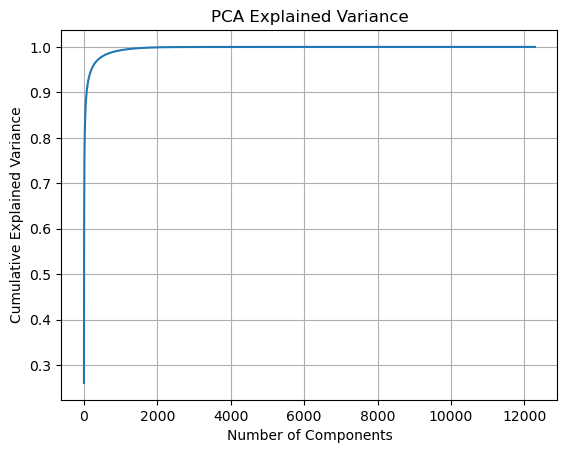

In [5]:
import matplotlib.pyplot as plt

# Apply PCA
pca = PCA()
pca.fit(trainX_flattened)

# Visualize explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

In [6]:
pca = PCA(n_components=2000)
trainX_pca = pca.fit_transform(trainX_flattened)

# Reconstruct the training data after PCA
trainX_reconstructed = pca.inverse_transform(trainX_pca)
trainX_reconstructed = trainX_reconstructed.reshape(trainX.shape)

# One-hot encode labels
trainY = to_categorical(trainY, num_classes=3)
testY = to_categorical(testY, num_classes=3)

# TensorBoard setup
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [7]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=64, height=64, depth=3, classes=3)

lr_schedule = ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=EPOCHS,
    decay_rate=0.96
)
opt = Adam(learning_rate=lr_schedule)

# model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


/Users/mafu/miniforge3/envs/ros_env_2/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-15 18:50:08.429353: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-15 18:50:08.429659: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-15 18:50:08.429663: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-15 18:50:08.430181: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-15 18:50:08.430444: I tensorflow/core/common_runtime/pluggable_device/pluggable_device

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',       # Metric to monitor (e.g., validation loss)
    patience=10,              # Number of epochs with no improvement after which training will stop
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored metric
)

# Training the model with early stopping
H = model.fit(
    trainX_reconstructed, trainY,
    batch_size=BS,
    validation_data=(testX, testY),
    epochs=EPOCHS,
    verbose=1,
    callbacks=[tensorboard_callback, early_stopping]
)

Epoch 1/100


2024-12-15 18:50:13.530565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


810/810 ━━━━━━━━━━━━━━━━━━━━ 43s 50ms/step - accuracy: 0.8280 - loss: 0.4638 - val_accuracy: 0.8803 - val_loss: 0.2799
Epoch 2/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 43s 53ms/step - accuracy: 0.8834 - loss: 0.2843 - val_accuracy: 0.8986 - val_loss: 0.2433
Epoch 3/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.8992 - loss: 0.2471 - val_accuracy: 0.9109 - val_loss: 0.2166
Epoch 4/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.9109 - loss: 0.2205 - val_accuracy: 0.9176 - val_loss: 0.2027
Epoch 5/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - accuracy: 0.9205 - loss: 0.1960 - val_accuracy: 0.9275 - val_loss: 0.1746
Epoch 6/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step - accuracy: 0.9304 - loss: 0.1757 - val_accuracy: 0.9345 - val_loss: 0.1649
Epoch 7/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - accuracy: 0.9399 - loss: 0.1547 - val_accuracy: 0.9392 - val_loss: 0.1535
Epoch 8/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - accuracy: 0.9425 - loss: 0.1485 - val_

In [9]:
# save the model to disk
print("[INFO] serializing network...")
model.save('./models_h5/self_driving_model_pca_2000.h5')

[INFO] serializing network...
